In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

from prophet import Prophet

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit

from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

In [2]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

In [9]:
import itertools

In [3]:
df = pd.read_csv('/Users/Daniyar/Mountains/Data/df_final_timeseries.csv', index_col="time")

In [4]:
df.head()

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,...,clouds_all_Valencia,weather_broken clouds_Valencia,weather_few clouds_Valencia,weather_light rain_Valencia,weather_others_Valencia,weather_scattered clouds_Valencia,weather_sky is clear_Valencia,hour,weekday,month
time,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,...,0.0,0,0,0,0,0,1,23.0,2.0,12.0
2015-01-01 00:00:00+00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,...,0.0,0,0,0,0,0,1,0.0,3.0,1.0
2015-01-01 01:00:00+00:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,43.0,...,0.0,0,0,0,0,0,1,1.0,3.0,1.0
2015-01-01 02:00:00+00:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,43.0,...,0.0,0,0,0,0,0,1,2.0,3.0,1.0
2015-01-01 03:00:00+00:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,43.0,...,0.0,0,0,0,0,0,1,3.0,3.0,1.0


In [5]:
df.index = pd.to_datetime(df.index)

In [6]:
def prep_split(df, columns_drop, label, train_end_date, hours_ahead):
    # Add a column with the label shifted by "hours" rows

    if hours_ahead == 0:
        df['label_shifted'] = df[label]
    else:
        df['label_shifted'] = df[label].shift(-hours_ahead)
        # Drop the last "hours" rows as they have no label values
        df = df.iloc[:-hours_ahead]
   
    
    def split_by_date(X, train_end_date):
        if not isinstance(train_end_date, pd.Timestamp):
            train_end_date = pd.Timestamp(train_end_date)

        # Convert index of X and y to Timestamp objects if they are strings
        if isinstance(X.index[0], str):
            X.index = pd.to_datetime(X.index)

        X_train = X[X.index <= train_end_date]
        X_test = X[X.index > train_end_date]

        return X_train, X_test

    X = df.drop(columns=columns_drop + ['label_shifted'])
    y = df['label_shifted']

    X_train, X_test = split_by_date(X, train_end_date)
    y_train, y_test = split_by_date(y, train_end_date)

    # Standardize all columns except target
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_train = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)

    X_test_scaled = scaler.transform(X_test)
    X_test = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

    return X_train, X_test, y_train, y_test

In [7]:
X_train, X_test, y_train, y_test = prep_split(df, 
                                               columns_drop=['price day ahead'], 
                                               label='price actual', 
                                               train_end_date='2017-12-31 23:00:00+00:00',
                                               hours_ahead=3)

In [17]:
model = sm.tsa.statespace.SARIMAX(y_train, 
                exog=X_train, 
                order=(1, 0, 1), 
                seasonal_order=(1, 0, 1, 12),  # Assuming monthly data with yearly seasonality
                enforce_stationarity=False, 
                enforce_invertibility=False)


results = model.fit()

forecast = results.get_forecast(steps=len(y_test), exog=X_test)
mean_forecast = forecast.predicted_mean

rmse = mean_squared_error(y_test, mean_forecast, squared=False)
print(rmse)

/Users/Daniyar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/Daniyar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           92     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.84878D+00    |proj g|=  3.44565D-01


 This problem is unconstrained.



At iterate    5    f=  2.79191D+00    |proj g|=  6.73948D-01

At iterate   10    f=  2.77509D+00    |proj g|=  7.51024D+00

At iterate   15    f=  2.76945D+00    |proj g|=  1.65236D-01

At iterate   20    f=  2.74334D+00    |proj g|=  1.33893D+00

At iterate   25    f=  2.72465D+00    |proj g|=  2.22143D+00

At iterate   30    f=  2.72373D+00    |proj g|=  1.69691D+00

At iterate   35    f=  2.69927D+00    |proj g|=  3.65858D+00

At iterate   40    f=  2.66208D+00    |proj g|=  4.25086D+00

At iterate   45    f=  2.66022D+00    |proj g|=  3.18197D-01

At iterate   50    f=  2.65841D+00    |proj g|=  5.42566D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/Daniyar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


12.134371396513666


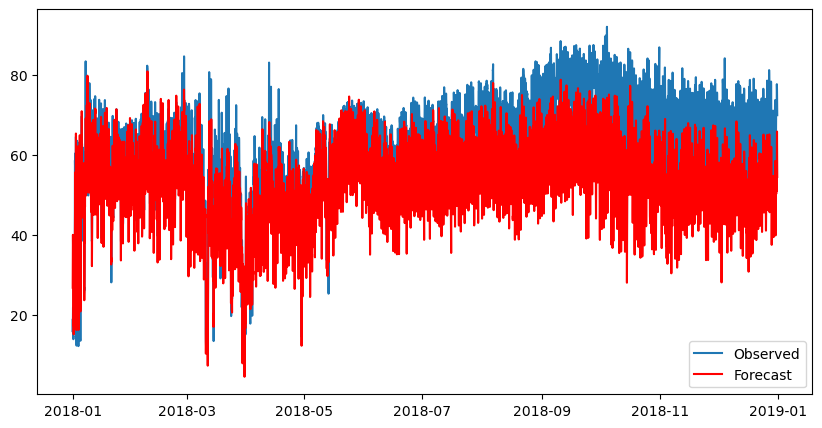

In [18]:
# Compare forecasted data with actual data
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label='Observed')
plt.plot(y_test.index, mean_forecast, label='Forecast', color='r')
plt.legend()
plt.show()

In [13]:
# Define the parameter grid
p = d = q = range(0, 2)  # Varying parameters for AR, differencing, and MA components
sp = sd = sq = range(0, 2)  # Varying parameters for seasonal AR, differencing, and MA components
seasonal = 12  # Assuming monthly data

# Generate all different combinations of p, d, q and seasonal pdq
pdq = [(x[0], x[1], x[2], 0) for x in list(itertools.product(p, d, q))]
seasonal_pdq = [(x[0], x[1], x[2], seasonal) for x in list(itertools.product(sp, sd, sq))]

best_aic = np.inf
best_params = None
best_seasonal_params = None
best_model = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            temp_model = sm.tsa.statespace.SARIMAX(y_train,
                                                   exog=X_train,
                                                   order=param,
                                                   seasonal_order=param_seasonal,
                                                   enforce_stationarity=False,
                                                   enforce_invertibility=False)
            results = temp_model.fit()
            
            # Replace AIC with whatever metric you prefer; lower AIC is generally better
            if results.aic < best_aic:
                best_aic = results.aic
                best_params = param
                best_seasonal_params = param_seasonal
                best_model = results
                
        except Exception as e:
            continue

print('Best SARIMAX{}x{}12 model - AIC:{}'.format(best_params, best_seasonal_params, best_aic))



Best SARIMAXNonexNone12 model - AIC:inf


In [14]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            temp_model = sm.tsa.statespace.SARIMAX(y_train,
                                                   exog=X_train,
                                                   order=param,
                                                   seasonal_order=param_seasonal,
                                                   enforce_stationarity=False,
                                                   enforce_invertibility=False)
            results = temp_model.fit()
            
            # Replace AIC with whatever metric you prefer; lower AIC is generally better
            if results.aic < best_aic:
                best_aic = results.aic
                best_params = param
                best_seasonal_params = param_seasonal
                best_model = results
                
        except Exception as e:
            continue

In [15]:
# Use the best model to forecast
forecast = best_model.get_forecast(steps=len(y_test), exog=X_test)
mean_forecast = forecast.predicted_mean
rmse = mean_squared_error(y_test, mean_forecast, squared=False)

print('RMSE: ', rmse)

AttributeError: 'NoneType' object has no attribute 'get_forecast'

In [19]:
def sarimax_model_selection(y_train, X_train, y_test, X_test, p, d, q, P, D, Q, s):
    """
    Fits a SARIMAX model with the given parameters and returns the RMSE on the test set.

    Parameters:
    - y_train: training target series.
    - X_train: training exogenous variables (if any).
    - y_test: testing target series.
    - X_test: testing exogenous variables (if any).
    - p: AR order for non-seasonal model.
    - d: Differencing order for non-seasonal model.
    - q: MA order for non-seasonal model.
    - P: AR order for seasonal model.
    - D: Differencing order for seasonal model.
    - Q: MA order for seasonal model.
    - s: Number of observations per season (seasonal periodicity).

    Returns:
    - rmse: Root Mean Square Error of the model's forecast on the test set.
    """
    model = sm.tsa.statespace.SARIMAX(y_train,
                                      exog=X_train,
                                      order=(p, d, q),
                                      seasonal_order=(P, D, Q, s),
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
    results = model.fit(disp=False)

    forecast = results.get_forecast(steps=len(y_test), exog=X_test)
    mean_forecast = forecast.predicted_mean

    rmse = mean_squared_error(y_test, mean_forecast, squared=False)
    return rmse

In [20]:
model2 = sarimax_model_selection(y_train, X_train, y_test, X_test, 1, 0, 2, 1, 0, 2, 12)
print(model2)

/Users/Daniyar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/Daniyar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/Daniyar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6.7907941612019505


In [21]:
def sarimax_model_selection(y_train, X_train, y_test, X_test, p, d, q, P, D, Q, s):
    """
    Fits a SARIMAX model with the given parameters and returns the RMSE on the test set.

    Parameters:
    - y_train: training target series.
    - X_train: training exogenous variables (if any).
    - y_test: testing target series.
    - X_test: testing exogenous variables (if any).
    - p: AR order for non-seasonal model.
    - d: Differencing order for non-seasonal model.
    - q: MA order for non-seasonal model.
    - P: AR order for seasonal model.
    - D: Differencing order for seasonal model.
    - Q: MA order for seasonal model.
    - s: Number of observations per season (seasonal periodicity).

    Returns:
    - rmse: Root Mean Square Error of the model's forecast on the test set.
    """
    model = sm.tsa.statespace.SARIMAX(y_train,
                                      exog=X_train,
                                      order=(p, d, q),
                                      seasonal_order=(P, D, Q, s),
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
    results = model.fit(disp=False)

    forecast = results.get_forecast(steps=len(y_test), exog=X_test)
    mean_forecast = forecast.predicted_mean

    rmse = mean_squared_error(y_test, mean_forecast, squared=False)
    return rmse, results, forecast, mean_forecast

In [22]:
rmse, results, forecast, mean_forecast = sarimax_model_selection(y_train, X_train, 
                                                                 y_test, X_test, 1, 0, 2, 1, 0, 2, 12)

/Users/Daniyar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/Daniyar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/Daniyar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [24]:
print(rmse)

6.7907941612019505


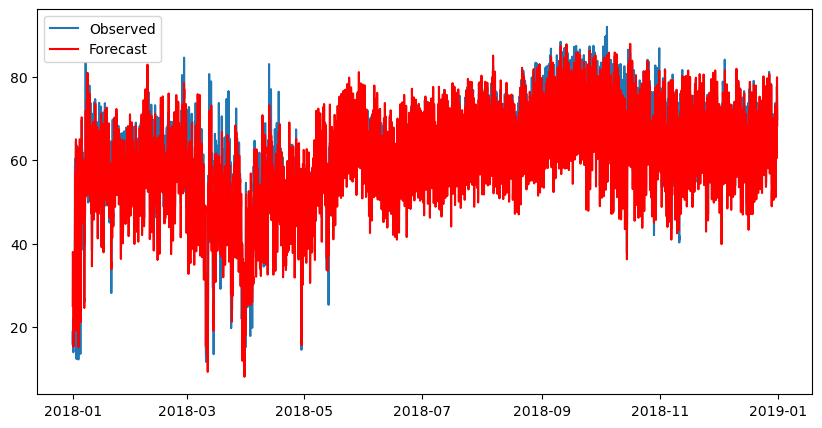

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label='Observed')
plt.plot(y_test.index, mean_forecast, label='Forecast', color='r')
plt.legend()
plt.show()

In [26]:
#Splitting with price day ahead column
X_train_pda, X_test_pda, y_train_pda, y_test_pda = prep_split(df, 
                                               columns_drop=[], 
                                               label='price actual', 
                                               train_end_date='2017-12-31 23:00:00+00:00',
                                               hours_ahead=3)

In [27]:
rmse, results, forecast, mean_forecast = sarimax_model_selection(y_train_pda, X_train_pda, 
                                                                 y_test_pda, X_test_pda, 1, 0, 2, 1, 0, 2, 12)

/Users/Daniyar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/Daniyar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/Daniyar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [28]:
print(rmse)

7.809362617791538


In [ ]:
rmse, results, forecast, mean_forecast = sarimax_model_selection(y_train_pda, X_train_pda, 
                                                                 y_test_pda, X_test_pda, 1, 0, 3, 1, 0, 3, 12)

In [29]:
imp_features = 

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,...,clouds_all_Valencia,weather_broken clouds_Valencia,weather_few clouds_Valencia,weather_light rain_Valencia,weather_others_Valencia,weather_scattered clouds_Valencia,weather_sky is clear_Valencia,hour,weekday,month
time,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,0.533220,-0.412519,-0.314110,0.185560,-2.617853,0.443016,0.439933,-0.325421,0.931667,-0.908754,...,-0.789879,-0.300829,-0.621117,-0.196089,-0.211372,-0.323925,1.075079,1.661206,-0.502842,1.588216
2015-01-01 00:00:00+00:00,0.555464,-0.415255,-0.159149,0.153055,-2.691747,0.513727,0.326215,-0.454400,0.931667,-0.908754,...,-0.789879,-0.300829,-0.621117,-0.196089,-0.211372,-0.323925,1.075079,-1.661332,-0.002719,-1.601035
2015-01-01 01:00:00+00:00,0.544342,-0.428934,-0.308387,0.067358,-2.710221,0.816421,0.228742,-0.607998,0.935287,-0.908754,...,-0.789879,-0.300829,-0.621117,-0.196089,-0.211372,-0.323925,1.075079,-1.516874,-0.002719,-1.601035
2015-01-01 02:00:00+00:00,0.433126,-0.617706,-0.547432,-0.154272,-2.654800,1.236966,0.163759,-0.924827,0.934081,-0.908754,...,-0.789879,-0.300829,-0.621117,-0.196089,-0.211372,-0.323925,1.075079,-1.372416,-0.002719,-1.601035
2015-01-01 03:00:00+00:00,0.321910,-0.801007,-0.628434,-0.297593,-2.728694,1.637663,0.174590,-0.956403,0.932874,-0.908754,...,-0.789879,-0.300829,-0.621117,-0.196089,-0.211372,-0.323925,1.075079,-1.227958,-0.002719,-1.601035


In [35]:
#Scaling y_variable

scaler_y = StandardScaler()

# Reshape, fit, and transform y_train
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))

# Transform y_test
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))



In [36]:
rmse_sc, results_sc, forecast_sc, mean_forecast_sc = sarimax_model_selection(y_train_scaled, X_train, 
                                                                 y_test_scaled, X_test, 1, 0, 2, 1, 0, 2, 12)

/Users/Daniyar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/Daniyar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/Daniyar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
forecast_sc.

In [37]:
print(rmse_sc)

0.5219941754528215


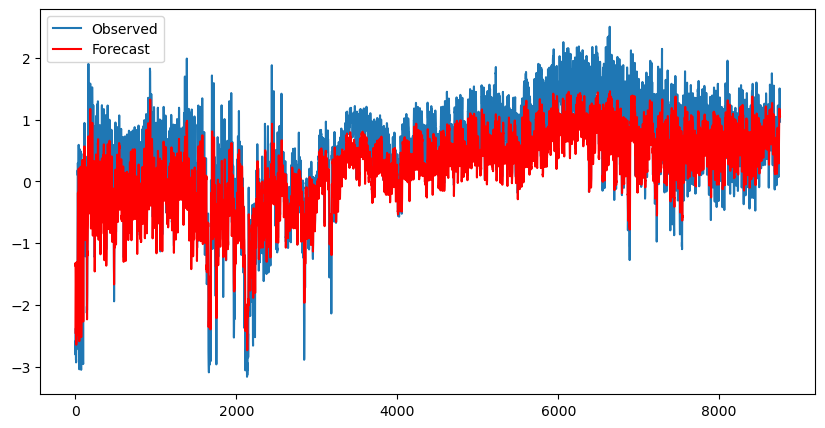

In [41]:

x_axis = range(len(y_test_scaled))

plt.figure(figsize=(10, 5))
plt.plot(x_axis, y_test_scaled, label='Observed')
plt.plot(x_axis, mean_forecast_sc, label='Forecast', color='r')
plt.legend()
plt.show()

In [49]:
# Inverse the scaling of the forecasted values
mean_forecast_sc_inverse = scaler_y.inverse_transform(mean_forecast_sc.values.reshape(-1, 1))

# Flatten the array to make it one-dimensional (optional, for consistency in output)
mean_forecast_sc_inverse = mean_forecast_sc_inverse.flatten()

In [48]:
mean_forecast_sc_inverse

array([[20.89302973],
       [25.77380649],
       [33.94604923],
       ...,
       [72.03211946],
       [71.68604952],
       [71.23728955]])

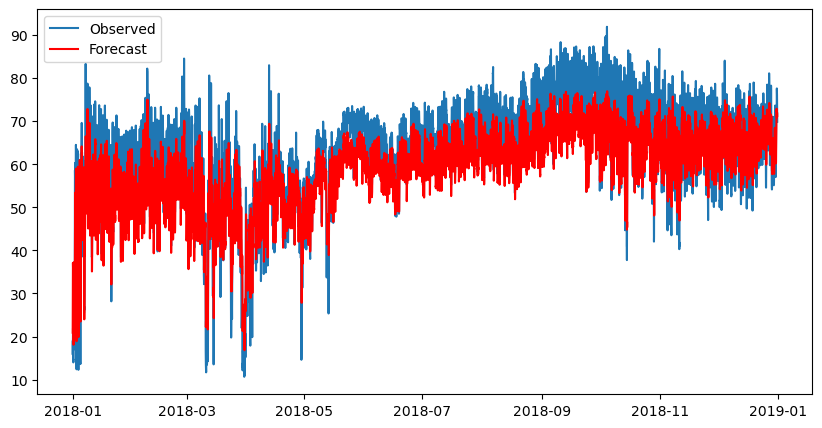

In [51]:
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label='Observed')
plt.plot(y_test.index, mean_forecast_sc_inverse, label='Forecast', color='r')
plt.legend()
plt.show()

In [52]:
rmse_sc = mean_squared_error(y_test, mean_forecast_sc_inverse, squared=False)
rmse_sc

7.48692361809478